In [1]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from display_utils import display_model
import pickle
import joblib
import os
import numpy as np
from scipy.interpolate import interp1d
from imu_base import calculate_patch_IMU_signals
import torch
from scipy.spatial.transform import Rotation as R
from imu_noise import add_imu_noise

/home/lala/miniconda3/envs/smpltojoint/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pkl_file = '/home/lala/Downloads/wham_output_1.pkl'
smpl_data = joblib.load(pkl_file)
print(smpl_data[0].keys())
loaded_data = smpl_data[0]

dict_keys(['pose', 'trans', 'pose_world', 'trans_world', 'betas', 'verts', 'frame_ids'])


In [3]:
# ----------------------------------------------------
# 1) Load original motion data
# ----------------------------------------------------
poses = loaded_data['pose']   # (N, 72)
betas = loaded_data['betas']  # (N, 10)
trans = loaded_data['trans']  # (N, 3)


In [4]:
# ----------------------------------------------------
# 2) Interpolate to high frequency
# ----------------------------------------------------
fps_original = 30
fps_high = 200
dt = 1.0 / fps_high

num_frames = poses.shape[0]
duration = num_frames / fps_original

t_original = np.linspace(0, duration, num_frames)
num_frames_high = int(duration * fps_high)
t_high = np.linspace(0, duration, num_frames_high)

# Interpolate translation
trans_high = np.zeros((num_frames_high, 3))
for d in range(3):
    f = interp1d(t_original, trans[:, d], kind='cubic')
    trans_high[:, d] = f(t_high)

# Interpolate poses (component-wise for simplicity)
poses_high = np.zeros((num_frames_high, poses.shape[1]))
for d in range(poses.shape[1]):
    f = interp1d(t_original, poses[:, d], kind='cubic')
    poses_high[:, d] = f(t_high)

In [5]:
# ----------------------------------------------------
# 3) Setup SMPL layer
# ----------------------------------------------------
smpl_layer = SMPL_Layer(
    center_idx=0,
    gender='neutral',
    model_root='smplpytorch/native/models'
)

cuda = torch.cuda.is_available()
if cuda:
    smpl_layer.cuda()

/home/lala/Documents/GitHub/smpl_to_joint/smplpytorch/pytorch/smpl_layer.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /croot/pytorch_1675190298929/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


In [6]:
print(f"Generating high-freq SMPL meshes: {num_frames_high} frames at {fps_high} Hz")

all_verts = []
all_jtr = []

for i in range(num_frames_high):
    pose_params = torch.tensor(poses_high[i:i+1], dtype=torch.float32)
    shape_params = torch.tensor(betas[0:1], dtype=torch.float32)

    if cuda:
        pose_params = pose_params.cuda()
        shape_params = shape_params.cuda()

    with torch.no_grad():
        verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)

    verts[:, :, 1] *= -1  # flip Y if needed
    #jtr[:, :, 1] *= -1

    # SAFE translation addition
    trans_torch = torch.tensor(trans_high[i:i+1], dtype=torch.float32)
    if cuda:
        trans_torch = trans_torch.cuda()

    verts = verts + trans_torch
    #jtr = jtr + trans_torch

    all_verts.append(verts.cpu().numpy())
    #all_jtr.append(jtr.cpu().numpy())

all_verts = np.array(all_verts) 
all_jtr = np.array(all_jtr)

print(f"Verts shape: {all_verts.shape}")


Generating high-freq SMPL meshes: 280 frames at 200 Hz
Verts shape: (280, 1, 6890, 3)


In [7]:
# ----------------------------------------------------
# 5) IMU cluster list
# ----------------------------------------------------
UTD_lists = {
    'right_wrist': {
        'verts': [5405, 5430, 5431]
    },
    'right_thigh': {
        'verts': [847, 849, 957]
    }
}

In [8]:
from imu_base import calculate_patch_IMU_signals
# ----------------------------------------------------
# 7) Compute & save for each patch IMU
# ----------------------------------------------------
save_dir = "/home/lala/2"
os.makedirs(save_dir, exist_ok=True)

for body_part, config in UTD_lists.items():
    verts = config['verts']

    print(f"Processing PATCH IMU: {body_part}")

    positions, orientations, linear_accel_loc, linear_accel_world, angular_velo = calculate_patch_IMU_signals(
        all_verts,
        verts,
        dt
    )

    file_path = os.path.join(save_dir, f'{body_part}.npz')
    np.savez(file_path,
             positions=positions,
             orientations=orientations,
             global_acceleration=linear_accel_world,
             local_accel=linear_accel_loc,
             angular_velocity=angular_velo)

    print(f"Saved PATCH IMU data: {file_path}")


Processing PATCH IMU: right_wrist
Saved PATCH IMU data: /home/lala/2/right_wrist.npz
Processing PATCH IMU: right_thigh
Saved PATCH IMU data: /home/lala/2/right_thigh.npz


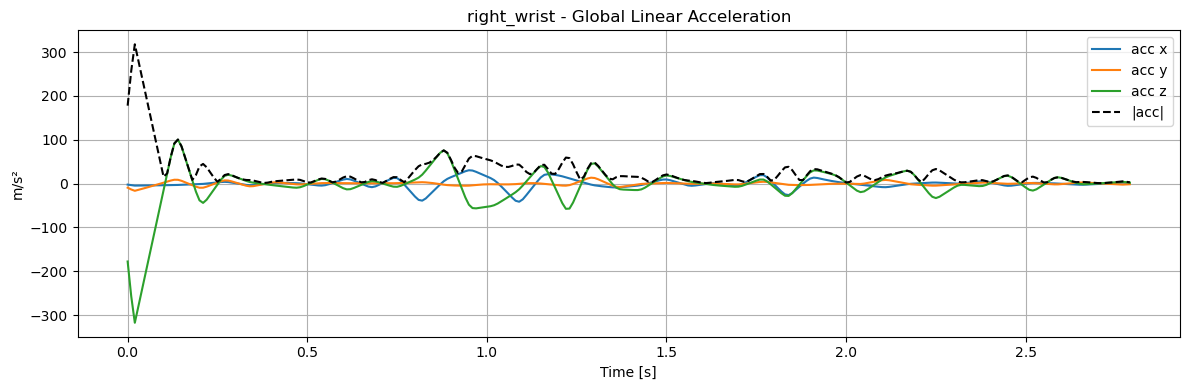

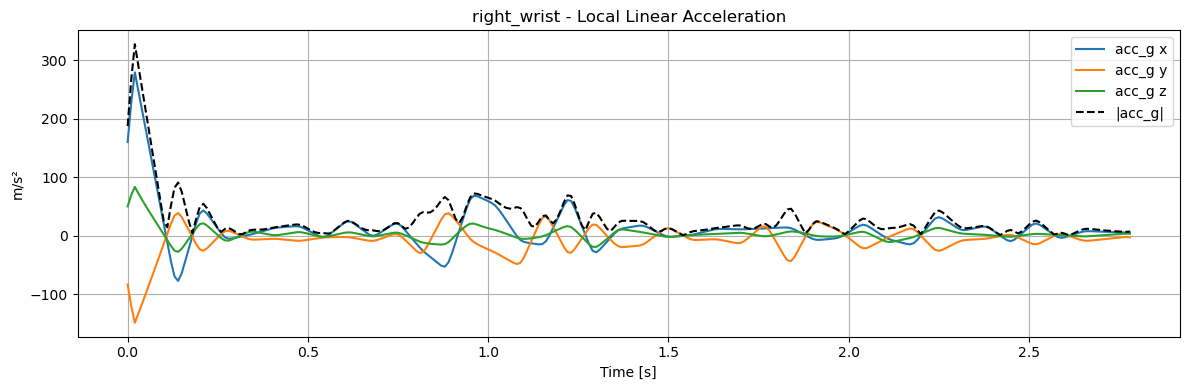

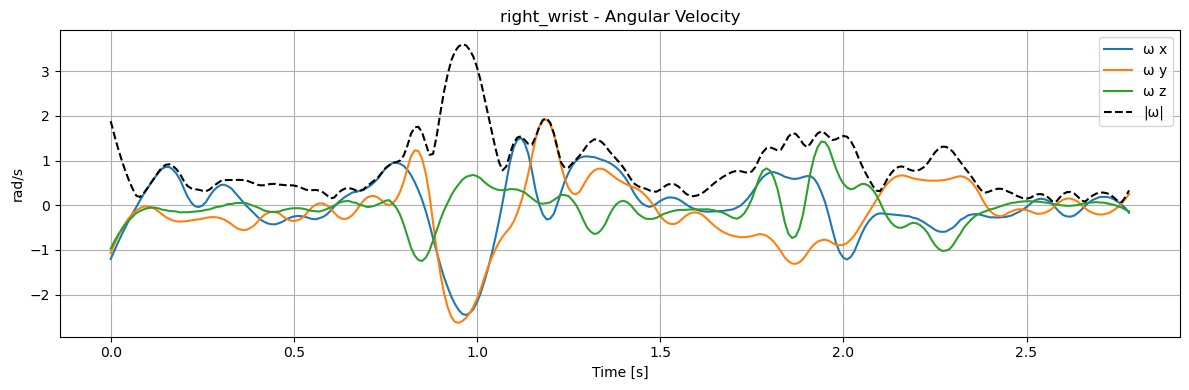

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
save_dir = r"/home/lala/2"
body_part = 'right_wrist'

file_path = os.path.join(save_dir, f'{body_part}.npz')
data = np.load(file_path)

acc = data['global_acceleration']
acc_g = data['local_accel']
ang_vel = data['angular_velocity']

fps = 100

# Time for acc
t_acc = np.arange(len(acc)) / fps

# Time for acc_g
t_acc_g = np.arange(len(acc_g)) / fps

# Time for ang_vel
t_ang = np.arange(len(ang_vel)) / fps

# --- Plot global linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Global Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc, acc[:, i], label=f'acc {axis}')
plt.plot(t_acc, np.linalg.norm(acc, axis=1), 'k--', label='|acc|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_g[:, i], label=f'acc_g {axis}')
plt.plot(t_acc_g, np.linalg.norm(acc_g, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot angular velocity ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Angular Velocity")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_ang, ang_vel[:, i], label=f'ω {axis}')
plt.plot(t_ang, np.linalg.norm(ang_vel, axis=1), 'k--', label='|ω|')
plt.xlabel('Time [s]')
plt.ylabel('rad/s')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


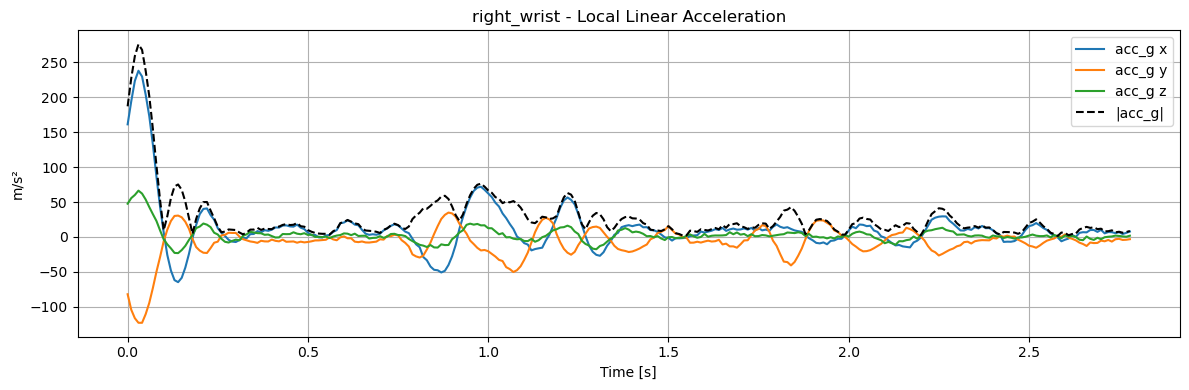

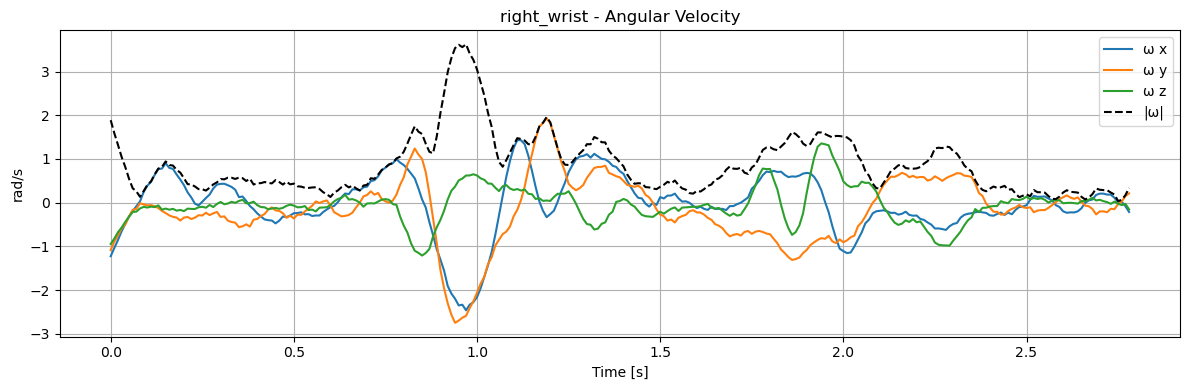

In [10]:
acc_realistic = add_imu_noise(acc_g, fs=fps_high, noise_type='full')
gyro_realistic = add_imu_noise(ang_vel, fs=fps_high, noise_type='full')

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_realistic[:, i], label=f'acc_g {axis}')
plt.plot(t_acc_g, np.linalg.norm(acc_realistic, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot angular velocity ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Angular Velocity")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_ang, gyro_realistic[:, i], label=f'ω {axis}')
plt.plot(t_ang, np.linalg.norm(gyro_realistic, axis=1), 'k--', label='|ω|')
plt.xlabel('Time [s]')
plt.ylabel('rad/s')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()